In [1]:
import math
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
import random
from scipy import stats
import sympy
import typing

random.seed(1)


In [2]:
nbm.print_metadata()


context: ci
hostname: c6cb1ee4daf6
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 2
nbname: maximum_likelihood_popsize_estimator_confidence_interval
nbpath: /opt/hereditary-stratigraph-concept/binder/popsize/maximum_likelihood_popsize_estimator_confidence_interval.ipynb
revision: null
session: 79a4edc5-c7b5-49ad-9305-3708190652d6
timestamp: 2022-12-06T19:51:16Z00:00


IPython==7.16.1
keyname==0.4.1
yaml==5.3.1
matplotlib==3.3.2
nbmetalog==0.2.6
numpy==1.21.5
pandas==1.1.2
scipy==1.5.4
sympy==1.5.1
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.3.0
json==2.0.9
ipykernel==5.5.3


# Goal

As a preliminary exercise, derive a confidence interval for estimation of population size $n$ from a single observation of fixed gene magnitude $x$.


# Strategy

The maximum likelihood estimator is given as

$\begin{align*}
\hat{n}_\mathrm{mle}
&= \frac{-k}{\sum_{i=1}^k \log(\boldsymbol{X}_i)}\\
&= \frac{-k}{\log(\prod_{i=1}^k \boldsymbol{X}_i)}
\end{align*}$

where the random variable $\boldsymbol{X}_i$ represents an independent observation of fixed gene magnitude in a population of size $n$.

Recall from [extrema_product_probability_density_function.ipynb](extrema_product_probability_density_function.ipynb), we have the probability density function for the product of $k$ fixed gene magnitudes given $n$ as,

$$p(x) = \frac{
   (-1)^k x^{n-1} n^{k+1} \log^{k}(x)
}{
(k-1)!
}.$$

In order to achieve a $c\%$ confidence interval, we must capture all $n$ that generate an as-or-less-extreme outcome as the observed $\hat{x}$ within the inner $c\%$ of probability mass.
In other words, for all $n$ *outside* the confidence interval less than $(1-c)\%$ of probability mass should be associated with an as-or-more-extreme outcome as observed.
(The observed outcome would only be generated with $(1-c)\%$ probability.)

We will take an even-tailed approach, so each tail of as-or-more-extreme outcomes for $n$ rejected from the confidence interval should contain no more than $(1-c)/2\%$ probability mass.


# Lower Bound

As the lower bound for our confidence interval estimating $n$, we will find the $n_\mathrm{lb}$ where integrating the upper tail of probability density beyond $\hat{x}$ contains only $(1-c)/2\%$ probability mass.

We find,

$\begin{align*}
(1-c)/2
&= \int_\hat{x}^1 \frac{
   (-1)^{k+1} x^{n_\mathrm{lb}-1} n_\mathrm{lb}^{k} \log^{k-1}(x)
}{
(k-1)!
} \, \mathrm{d}x\\
&= \frac{(-1)^{k+1} n_\mathrm{lb}^{k}}{(k-1)!}
\int_\hat{x}^1 x^{n_\mathrm{lb}-1} \log^{k-1}(x) \, \mathrm{d}x.
\end{align*}$

Sympy can perform this integration, but very slowly.
[WolframAlpha](https://www.wolframalpha.com/input?i=%5Cint+x%5E%7Bn-1%7D+%5Clog%5E%7Bk-1%7D%28x%29+%5C%2C+%5Cmathrm%7Bd%7Dx) gives it as

$\begin{align*}
\int x^{n-1} \log^{k-1}(x) \, \mathrm{d}x
&=
\frac{ -\Gamma(k, -n\log(x)) \log^k(x)}{n(-n \log(x))^k}\\
&=
\frac{ (-1)^{k+1} \Gamma(k, -n\log(x)) }{n^{k+1}}.
\end{align*}$

Applying the integration,

$\begin{align*}
(1-c)/2
&= \frac{(-1)^k n_\mathrm{lb}^{k+1}}{(k-1)!}
\int_\hat{x}^1 x^{n_\mathrm{lb}-1} \log^{k}(x) \, \mathrm{d}x\\
&= \frac{(-1)^k n_\mathrm{lb}^{k+1}}{(k-1)!}
\Big[ \frac{ (-1)^{k+1} \Gamma(k, -n_\mathrm{lb}\log(x)) }{n_\mathrm{lb}^{k+1}} \Big]_\hat{x}^1\\
&= \frac{-1}{(k-1)!}
\Big[ \Gamma(k, -n_\mathrm{lb}\log(x)) \Big]_\hat{x}^1\\
&= \frac{1}{(k-1)!}
\Big[ \Gamma(k, -n_\mathrm{lb}\log(1)) - \Gamma(k, -n_\mathrm{lb}\log(\hat{x})) \Big] \\
&= \frac{1}{(k-1)!}
\Big[ \Gamma(k, 0) - \Gamma(k, -n_\mathrm{lb}\log(\hat{x})) \Big] \\
&= \frac{1}{\Gamma(k)}
\Big[ \Gamma(k) - \Gamma(k, -n_\mathrm{lb}\log(\hat{x})) \Big] \\
&= 1 - \frac{\Gamma(k, -n_\mathrm{lb}\log(\hat{x}))}{\Gamma(k)}\\
(-1-c)/2
&= - \frac{\Gamma(k, -n_\mathrm{lb}\log(\hat{x}))}{\Gamma(k)}\\
(c+1)/2
&= \frac{\Gamma(k, -n_\mathrm{lb}\log(\hat{x}))}{\Gamma(k)}\\
\frac{(c+1)\Gamma(k)}{2}
&= \Gamma(k, -n_\mathrm{lb}\log(\hat{x}))\\
0
&= \Gamma(k, -n_\mathrm{lb}\log(\hat{x})) - \frac{(c+1)\Gamma(k)}{2}\\
0
&= 2\Gamma(k, -n_\mathrm{lb}\log(\hat{x})) - (c+1)\Gamma(k).
\end{align*}$

Past this point, $n_\mathrm{lb}$ must be solved for numerically.


In [3]:
def solve_mle_popsize_ci_lb(
    observations: typing.List[float],
    *,
    confidence: float,
) -> float:

    k = len(observations)
    hat_x = math.prod(observations)

    # use mle estimate as starting guess
    hat_n_mle = -k/math.log(hat_x)

    n_lb = sympy.Symbol('n_\mathrm{lb}', positive=True, real=True,)

    return float(sympy.nsolve(
        2 * sympy.uppergamma(k, -n_lb * sympy.log(hat_x))
        - (confidence+1) * sympy.gamma(k),
        hat_n_mle,
        verify=False,
    ))


# Upper Bound

As the upper bound for our confidence interval estimating $n$, we will find the $n_\mathrm{ub}$ where integrating the lower tail of probability density beyond $\hat{x}$ contains only $(1-c)/2\%$ probability mass.

$\begin{align*}
(1-c)/2
&= \int_0^\hat{x} \frac{
   (-1)^{k+1} x^{n_\mathrm{lb}-1} n_\mathrm{lb}^{k} \log^{k-1}(x)
}{
(k-1)!
} \, \mathrm{d}x\\
&= \frac{(-1)^{k+1} n_\mathrm{lb}^{k}}{(k-1)!}
\int_0^\hat{x} x^{n_\mathrm{lb}-1} \log^{k-1}(x) \, \mathrm{d}x.
\end{align*}$

Applying the integration as before above,

$\begin{align*}
(1-c)/2
&= \frac{(-1)^k n_\mathrm{ub}^{k+1}}{(k-1)!}
\int_0^\hat{x} x^{n_\mathrm{ub}-1} \log^{k}(x) \, \mathrm{d}x\\
&= \frac{(-1)^k n_\mathrm{ub}^{k+1}}{(k-1)!}
\Big[ \frac{ (-1)^{k+1} \Gamma(k, -n_\mathrm{ub}\log(x)) }{n_\mathrm{ub}^{k+1}} \Big]_0^\hat{x}\\
&= \frac{-1}{(k-1)!}
\Big[ \Gamma(k, -n_\mathrm{ub}\log(x)) \Big]_0^\hat{x}\\
&= \frac{1}{(k-1)!}
    \Big[ \Gamma(k, -n_\mathrm{ub}\log(\hat{x})) - \Gamma(k, -n_\mathrm{ub}\log(0)) \Big] \\
&= \frac{1}{(k-1)!}
\Big[ \Gamma(k, -n_\mathrm{ub}\log(\hat{x})) - \Gamma(k, -\infty) \Big] \\
&= \frac{1}{\Gamma(k)}
\Big[ \Gamma(k, -n_\mathrm{ub}\log(\hat{x})) \Big] \\
&= \frac{\Gamma(k, -n_\mathrm{ub}\log(\hat{x}))}{\Gamma(k)}\\
(1-c)/2
&= \frac{\Gamma(k, -n_\mathrm{ub}\log(\hat{x}))}{\Gamma(k)}\\
(1-c)/2
&= \frac{\Gamma(k, -n_\mathrm{ub}\log(\hat{x}))}{\Gamma(k)}\\
\frac{(1-c)\Gamma(k)}{2}
&= \Gamma(k, -n_\mathrm{ub}\log(\hat{x}))\\
0
&= \Gamma(k, -n_\mathrm{ub}\log(\hat{x})) - \Gamma(k)(1-c)/2\\
&= 2\Gamma(k, -n_\mathrm{ub}\log(\hat{x})) - \Gamma(k)(1-c).
\end{align*}$

Past this point, $n_\mathrm{ub}$ must be solved for numerically.


In [4]:
def solve_mle_popsize_ci_ub(
    observations: typing.List[float],
    *,
    confidence: float,
) -> float:

    k = len(observations)
    hat_x = math.prod(observations)

    # use mle estimate as starting guess
    hat_n_mle = -k/math.log(hat_x)

    n_lb = sympy.Symbol('n_\mathrm{ub}', positive=True, real=True,)

    return float(sympy.nsolve(
        2 * sympy.uppergamma(k, -n_lb * sympy.log(hat_x))
        - (1-confidence) * sympy.gamma(k),
        hat_n_mle,
        verify=False,
    ))


# Simulated Experiments


In [5]:
def sample_observations(true_popsize: int, k: int,) -> typing.List[float]:
    """Simulate `k` samples of the largest gene from within a population of `true_popsize`."""

    return [
        max(random.random() for __ in range(true_popsize))
        for __ in range(k)
    ]

def calculate_popsize_confidence_interval(
    observations: typing.List[float],
    confidence: float,
) -> typing.Tuple[float, float]:
    """Calculate confidence interval for true population size $n$
    given observed fixed gene magnitude $\hat{x}$."""

    lb = solve_mle_popsize_ci_lb(observations, confidence=confidence,)
    ub = solve_mle_popsize_ci_ub(observations, confidence=confidence,)

    return (lb, ub,)

def sample_popsize_confidence_interval(
    true_popsize: int,
    k: int,
    confidence: float,
) -> typing.Tuple[float, float]:
    """Generate a sampled largest gene from a `true_popsize` population `k` times
    and then to calculate a confidence interval for `true_popsize`
    based on that sampled largest gene."""

    return calculate_popsize_confidence_interval(
        sample_observations(true_popsize, k),
        confidence,
    )


In [6]:
# simulate gene drive within populations and then subsequent estimates of population size from magnitude of fixed genes
records = []
for true_popsize in 10, 100,:
    for k in 1, 10,:
        for confidence in 0.95, 0.99,:
            sampled_cis = [
                sample_popsize_confidence_interval(
                    true_popsize,
                    k,
                    confidence,
                )
                for __ in range(100)
            ]

            num_confidence_intervals_containing_true_popsize = sum(
                bool(lb_ <= true_popsize <= ub_)
                for lb_, ub_ in sampled_cis
            )

            records.append({
                'True Population Size' : true_popsize,
                'Confidence' : confidence,
                'Mean Normalized Confidence Interval lower bound' : np.mean([lb_ for lb_, ub_ in sampled_cis]) / true_popsize,
                'Mean Normalized Confidence Interval upper bound' : np.mean([ub_ for lb_, ub_ in sampled_cis]) / true_popsize,
                'Mean Normalized Confidence Interval width' : np.mean([ub_ - lb_ for lb_, ub_ in sampled_cis]) / true_popsize,
                f'Fraction Estimates within Confidence Interval'
                    : num_confidence_intervals_containing_true_popsize / len(sampled_cis),
                'Num Observations' : k,
                'p As Many Estimates Outside Confidence Interval'
                    : stats.binom.cdf(num_confidence_intervals_containing_true_popsize, len(sampled_cis), confidence),
            })

res_df = pd.DataFrame.from_records(records)
res_df.round(5)


,True Population Size,Confidence,Mean Normalized Confidence Interval lower bound,Mean Normalized Confidence Interval upper bound,Mean Normalized Confidence Interval width,Fraction Estimates within Confidence Interval,Num Observations,p As Many Estimates Outside Confidence Interval
0,10,0.95,0.12995,18.93401,18.80406,0.97,1,0.88174
1,10,0.99,0.03415,36.09368,36.05953,1.00,1,1.00000
2,10,0.95,0.51778,1.84471,1.32693,0.92,10,0.12796
3,10,0.99,0.42502,2.28674,1.86173,0.99,10,0.63397
4,100,0.95,0.08217,11.97308,11.89090,0.99,1,0.99408
5,100,0.99,0.01368,14.45913,14.44545,1.00,1,1.00000
6,100,0.95,0.52591,1.87368,1.34777,0.93,10,0.23399
7,100,0.99,0.41121,2.21245,1.80124,0.99,10,0.63397


Simulated experiments show the expected fractions of estimates falling within calculated confidence intervals.


# Confidence Interval Width Versus $n$

For the lower bound with fixed $k$,

$\begin{align*}
C = -n_\mathrm{lb} \log(\hat{x})
\end{align*}$

where C is a constant.

For a single observation of fixed gene magnitude $\boldsymbol{X}_i$,

$\begin{align*}
E(\boldsymbol{X}_i)
&= \int_0^1 x p(x_i) \, dx_i\\
&= \int_0^1 x nx_i^{n-1} \, dx_i\\
&= \int_0^1 nx_i^n \, dx_i\\
&= \frac{n}{n+1}x_i^{n+1} |_0^1 \, dx_i\\
&= \frac{n}{n+1}(1^{n+1} - 0^{n+1})\\
&= \frac{n}{n+1}.
\end{align*}$

Because $\boldsymbol{X}_i$ are independent for $\boldsymbol{X} = \prod_{i=1}^k \boldsymbol{X}_i$, we have

$\begin{align*}
E(\boldsymbol{X})
&= E(\prod_{i=1}^k \boldsymbol{X}_i) \\
&= \prod_{i=1}^k E(\boldsymbol{X}) \\
&= \prod_{i=1}^k \frac{n}{n+1} \\
&= \Big(\frac{n}{n+1}\Big)^k.
\end{align*}$

Substituting and rearranging,

$\begin{align*}
C
&= -n_\mathrm{lb} \log\Big(\frac{n}{n+1}^k\Big) \\
&= -n_\mathrm{lb} k\log\Big(\frac{n}{n+1}\Big) \\
&= n_\mathrm{lb} \log\Big(\frac{n}{n+1}\Big).
\end{align*}$

Does $n_\mathrm{lb}$ scale linearly with $n$?

$\begin{align*}
C
&\stackrel{?}{=}
\lim_{n \to \infty} n \log\Big(\frac{n}{n+1}\Big) \\
&\stackrel{?}{=}
\lim_{n \to \infty} \frac{\log\Big(\frac{n}{n+1}\Big)}{1/n} \\
&\stackrel{?}{=}
\lim_{n \to \infty} \frac{\frac{\mathrm{d}}{\mathrm{d}n} \log\Big(\frac{n}{n+1}\Big)}{\frac{\mathrm{d}}{\mathrm{d}n} 1/n} \\
&\stackrel{?}{=}
\lim_{n \to \infty} \frac{ \frac{1}{n^2 + n}}{\frac{-1}{n^{2}}} \\
&\stackrel{?}{=}
\lim_{n \to \infty} -\frac{n^{2}}{n^2 + n} \\
&\stackrel{?}{=}
\lim_{n \to \infty} -\frac{1}{1 + 1/n} \\
&\stackrel{\checkmark}{=}
\lim_{n \to \infty} -\frac{1}{1 + 0}.
\end{align*}$

The same holds for the upper bound, so the width of the confidence interval will scale as a constant factor of $n$ as $n \to \infty$.


# Confidence Interval Width Versus $n$ Sanity Check

As a sanity check, let's inspect the plots $y=x$ and $y=-\frac{1}{\log(\frac{n}{n+1})}$ to make sure they look similar.


/usr/local/lib/python3.8/dist-packages/sympy/plotting/plot.py:1065: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['left'].set_smart_bounds(True)
/usr/local/lib/python3.8/dist-packages/sympy/plotting/plot.py:1066: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['bottom'].set_smart_bounds(False)


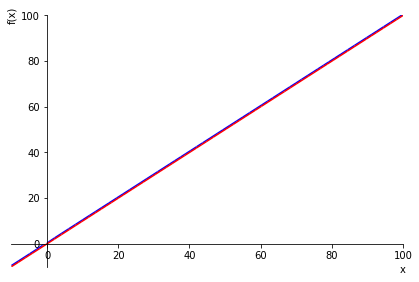

In [7]:
x = sympy.Symbol('x')
ax = sympy.plotting.plot(
    -1/sympy.log(x/(x+1)),
    x,
    (x, -10, 100),
    ylim=(-10, 100),
    show=False,
)
ax[0].line_color = 'blue'
ax[1].line_color = 'red'
ax.show()


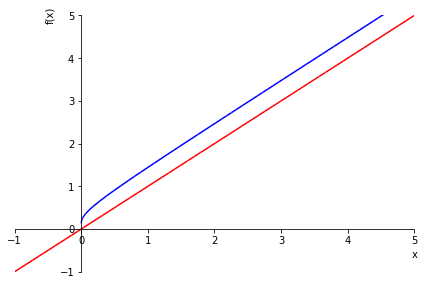

In [8]:
x = sympy.Symbol('x')
ax = sympy.plotting.plot(
    -1/sympy.log(x/(x+1)),
    x,
    (x, -1, 5),
    ylim=(-1, 5),
    show=False,
)
ax[0].line_color = 'blue'
ax[1].line_color = 'red'
ax.show()


# Result

For $k$ observations of fixed gene magnitude $\hat{x}_i$, the population size $n$ can be estimated with $c\%$ confidence to fall within the interval $(\hat{n}_\mathrm{lb}, \hat{n}_\mathrm{ub})$ where $\hat{n}_\mathrm{lb}$ is the solution to

$\begin{align*}
0
&= 2\Gamma(k, -\hat{n}_\mathrm{lb}\log(\prod_{i=1}^k\hat{x}_i)) - (c+1)\Gamma(k).
\end{align*}$

and $\hat{n}_\mathrm{ub}$ is the solution to

$\begin{align*}
0 &= 2\Gamma(k, -\hat{n}_\mathrm{ub}\log(\prod_{i=1}^k\hat{x}_i))) - \Gamma(k)(1-c).
\end{align*}$


Simulated experiments support the validity of this result.
About ten independent observations are required for 95\% confidence estimate within a factor of 2 and 15 for a 99\% confidence estimate within a factor of 2.
